# Model analysis

In [1]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Import custom modules
from utils.data import *
from utils.metrics import *

In [3]:
# Read training dataset and select by groups with most uncertainty
df = pd.read_csv('../data/train-aug.csv').drop_duplicates()
df = df[(df.group_type == 1) | (df.group_type == 2)]
#df = df[df.group_type == 0]
df.shape

(77202, 14)

In [4]:
# Group target feature names. Categorical features are handled by label encoder. NOTES:
# - equiment_area: ignored as test dataset contains values not found in train data
# - group_type: ignored as training data is already selected by group
categorical_feature_names = [
    'action_recommendation_id',
    'action_recommendation_category',
    #'equipment_area',
    'equipment_category',
    'usage_type',
    #'group_type'
]
numeric_feature_names = [
    'floors_category',
    'load_category',
    'speed_category',
]

In [5]:
# Employ label encoder to convert categories to numeric
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
label_encoder = defaultdict(LabelEncoder)
label_encoder

defaultdict(sklearn.preprocessing._label.LabelEncoder, {})

In [6]:
# Group features and labels
x = pd.concat([df[categorical_feature_names].apply(lambda f: label_encoder[f.name].fit_transform(f)),
    df[numeric_feature_names]], axis=1)
y = df.feedback
x.shape, y.shape

((77202, 7), (77202,))

In [7]:
# Verify that data looks valid
x.head()

,action_recommendation_id,action_recommendation_category,equipment_category,usage_type,floors_category,load_category,speed_category
2,84,2,6,10,7,6,6
3,57,2,14,4,8,7,8
5,94,2,6,10,7,6,5
6,94,2,4,10,8,4,6
8,94,2,12,6,8,6,6


In [8]:
# Show histogram of features
#x.hist(figsize=(15, 10))

In [9]:
# Apply train, test split for simple validation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((69481, 7), (7721, 7), (69481,), (7721,))

In [10]:
# Explore label imbalance
y_train[y_train == 1].size / y_train.size, y_test[y_test == 1].size / y_test.size

(0.8280537125257265, 0.8373267711436343)

In [11]:
%%time
#from sklearn.ensemble import RandomForestClassifier
#rf = RandomForestClassifier()
#rf.fit(x_train, y_train)
#rf.score(x_test, y_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [12]:
#y_pred = (rf.predict_proba(x_test)[:, 1] > 0.10).astype(float)
#y_pred

In [13]:
#f2_score(y_test, y_pred)

In [14]:
#f2_score(y_test, np.ones_like(y_test))

In [15]:
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))
#print(classification_report(y_test, np.ones_like(y_test), zero_division=False))

# Model

We train a gradient boosting model for predicting the labels in groups 1 and 2. Since the accuracy for groups 0 and 3 is near 100% percent in the baseline we can skip them as there is no improvement from the model. We use XGBoost with hyperparameter tuning for predicting the label.

In [16]:
# Best performing model config with K=5,10
model_config = {}

In [17]:
%%time
from xgboost import XGBClassifier
clf = XGBClassifier(use_label_encoder=False, random_state=0, **model_config)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

[03:35:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 8.46 s, sys: 346 ms, total: 8.81 s
Wall time: 1.67 s


0.8478176402020464

In [18]:
# Apply prediction threshold
y_pred = (clf.predict_proba(x_test)[:, 1] > 0.35).astype(float)
y_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [19]:
# Model baseline f2
f2_score(y_test, y_pred)

0.9615097494699753

In [20]:
# Naive baseline f2
f2_score(y_test, np.ones_like(y_test))

0.9625978976206784

In [21]:
# Show basic evaluation metrics
print(confusion_matrix(y_test, clf.predict(x_test)))
print(classification_report(y_test, clf.predict(x_test)))
print(classification_report(y_test, np.ones_like(y_test), zero_division=False))

[[ 173 1083]
 [  92 6373]]
              precision    recall  f1-score   support

           0       0.65      0.14      0.23      1256
           1       0.85      0.99      0.92      6465

    accuracy                           0.85      7721
   macro avg       0.75      0.56      0.57      7721
weighted avg       0.82      0.85      0.80      7721

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1256
           1       0.84      1.00      0.91      6465

    accuracy                           0.84      7721
   macro avg       0.42      0.50      0.46      7721
weighted avg       0.70      0.84      0.76      7721



array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

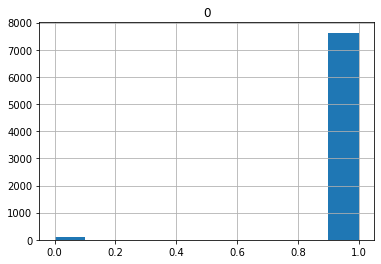

In [22]:
# Show output prediction 
pd.DataFrame(y_pred).hist()

# Shap explainer

Shapley values can be used to measure the contribution of each feature to model output. We use lightgbm as base model here for compatibility reasons.

In [23]:
import shap; shap.initjs()

In [27]:
%%time
import lightgbm
lgb = lightgbm.LGBMClassifier(random_state=0).fit(x_train, y_train)
lgb.score(x_test, y_test)

CPU times: user 4.21 s, sys: 216 ms, total: 4.43 s
Wall time: 862 ms


0.8445797176531538

In [25]:
# Create subsamble from test data and obtain shap value
sample = x_test.values[np.random.permutation(x_test.shape[0])[:1000]]
explainer = shap.TreeExplainer(lgb)
shap_values = explainer.shap_values(sample)

C extension was not built during install!


/Users/andreas/.pyenv/versions/3.8.2/envs/research/lib/python3.8/site-packages/shap/explainers/tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


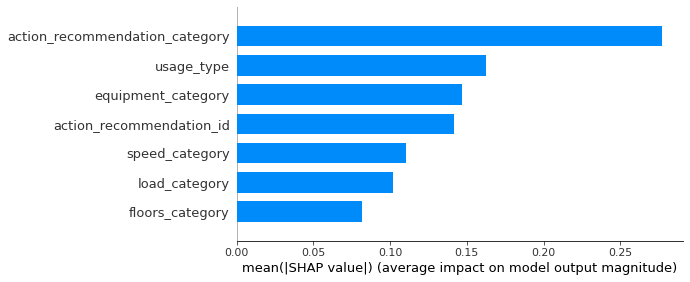

In [26]:
# Show shap summary plot
shap.summary_plot(
    shap_values[0],
    features=sample,
    feature_names=x_test.columns,
    plot_type='bar'
)

# Tree plots

Plotting the decision trees highlights the basic principles how weak learners produce output. The visualization is directly interpretable as selection rules and each subsequent tree improves the accuracy of the output.

<AxesSubplot:>

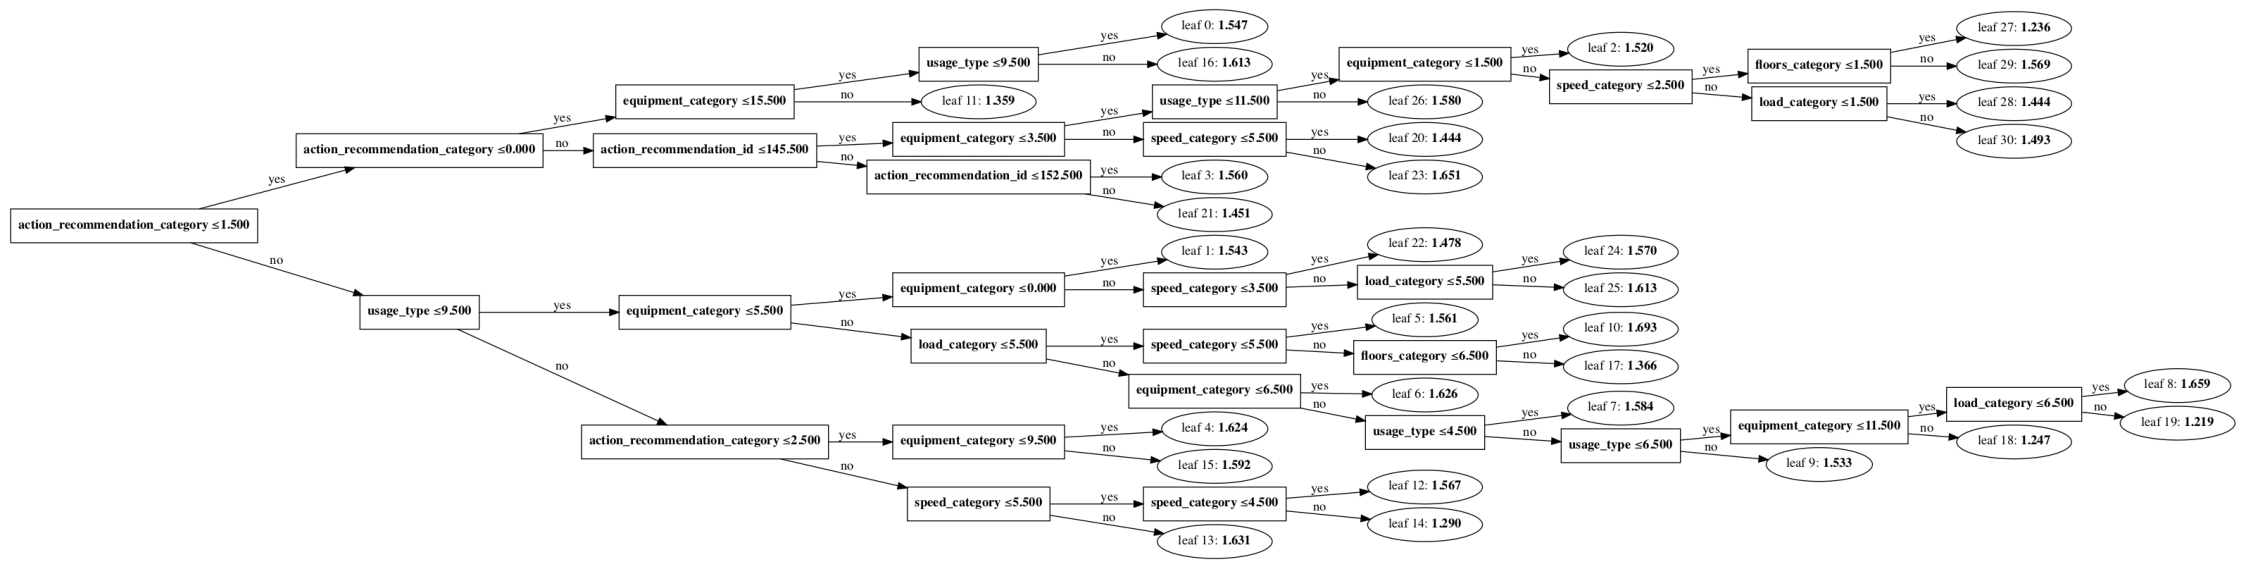

In [28]:
# First tree
lightgbm.plot_tree(lgb, tree_index=0, figsize=(40, 30))

<AxesSubplot:>

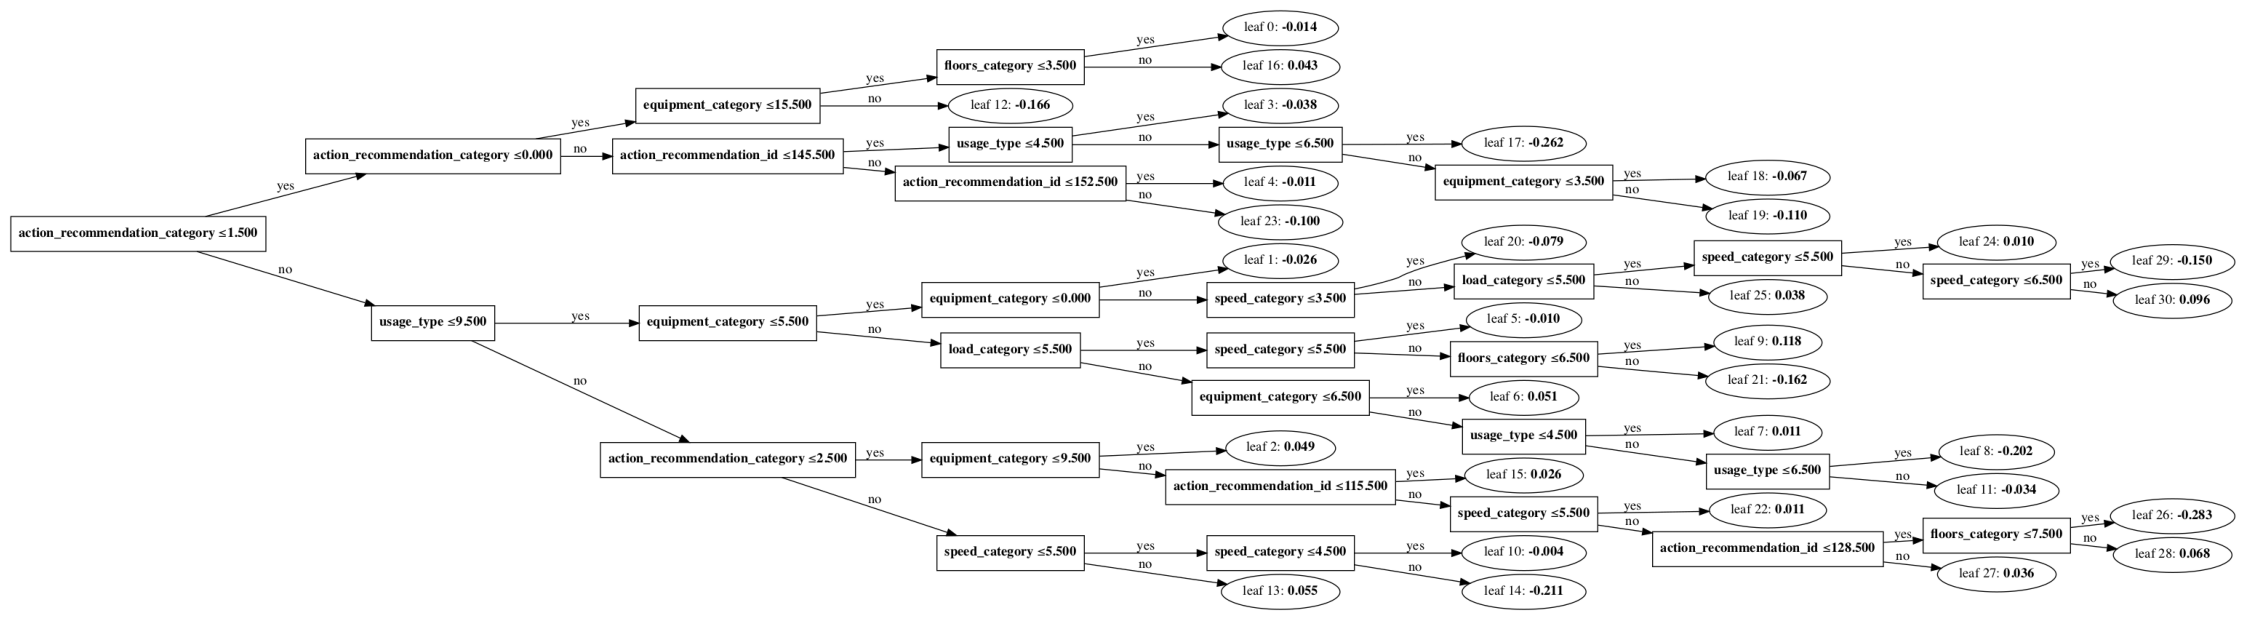

In [29]:
# Second tree
lightgbm.plot_tree(lgb, tree_index=1, figsize=(40, 30))

<AxesSubplot:>

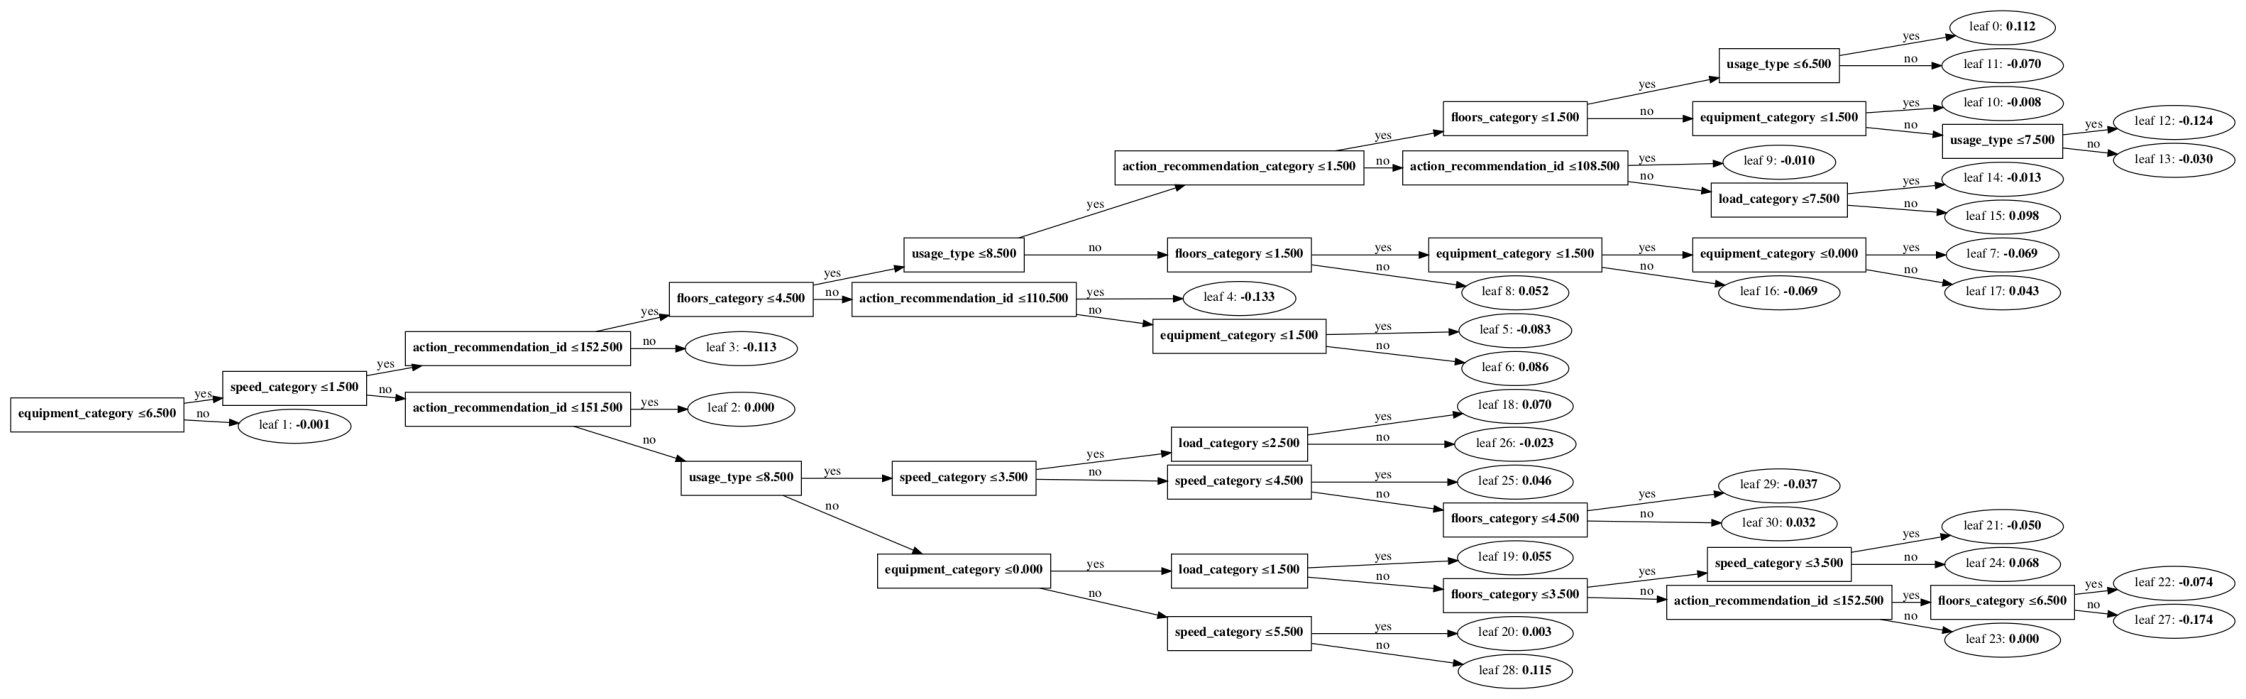

In [30]:
# Last tree
lightgbm.plot_tree(lgb, tree_index=-1, figsize=(40, 30))

# Test submission

Finally we use the trained model with optimized hyperparameters to generate the test data submission. We use the model for groups 1 and 2 and set groups 0 and 3 to 1 (per baseline accuracy).

In [31]:
# Read test data file with group ids, assign a new column "feedback" with 1 as default value
df_test = pd.read_csv('../data/test-aug.csv').assign(feedback=1)
df_test.head()

,case_id,equipment_id,completion_date,action_recommendation_id,action_recommendation_type,action_recommendation_category,equipment_area,usage_type,speed_category,load_category,floors_category,equipment_category,group_type,feedback
0,9d54504e-c805-4859-b92e-a8df797323e7,ele0030053,2019-06-04,ar00000250,art01,arc03,ga00000073,ut005,7,6,8,tp013,0,1
1,554e89db-0d65-44f1-a3cb-d79662cd1058,ele0030057,2019-06-04,ar00000188,art01,arc03,ga00000061,ut001,4,7,1,tp005,0,1
2,6cb91017-5e91-446b-9064-409758334cea,ele0030180,2019-06-04,ar00000005,art01,arc02,ga00000600,ut011,4,3,4,tp003,0,1
3,496f3fe9-36a6-4b44-a686-5383584c4653,ele0030224,2019-06-04,ar00000124,art01,arc03,ga00000136,ut011,5,4,6,tp008,2,1
4,f8189755-b79e-4114-8a2b-84e08a2263f9,ele0030580,2019-06-04,ar00000250,art01,arc03,ga00000529,ut011,6,4,7,tp006,3,1


In [32]:
# Show group counts
df_test.groupby('group_type').size()

group_type
0     5863
1     2666
2    16546
3     4353
dtype: int64

In [33]:
# Select groups 1 & 2 for model input, collect features and apply label encoder
test_input_mask = (df_test.group_type == 1) | (df_test.group_type == 2)
model_test_input = df_test[test_input_mask]
model_test_input = pd.concat([
    model_test_input[categorical_feature_names].apply(lambda f: label_encoder[f.name].transform(f)),
    model_test_input[numeric_feature_names]], axis=1)
model_test_input.head()

,action_recommendation_id,action_recommendation_category,equipment_category,usage_type,floors_category,load_category,speed_category
3,63,2,8,10,6,4,5
6,94,2,8,10,7,6,5
8,141,2,4,10,8,6,7
9,94,2,4,4,8,7,8
12,57,2,8,10,5,4,5


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

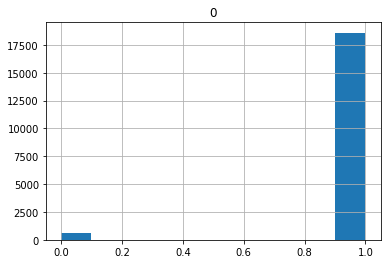

In [34]:
# Show predicted values histogram
pd.DataFrame(clf.predict(model_test_input)).hist()

In [35]:
# Assign predicted feedback labels
df_test.loc[test_input_mask, 'feedback'] = clf.predict(model_test_input)

In [36]:
# Select output columns
test_output = df_test[['case_id', 'action_recommendation_id', 'feedback']]
test_output

,case_id,action_recommendation_id,feedback
0,9d54504e-c805-4859-b92e-a8df797323e7,ar00000250,1
1,554e89db-0d65-44f1-a3cb-d79662cd1058,ar00000188,1
2,6cb91017-5e91-446b-9064-409758334cea,ar00000005,1
3,496f3fe9-36a6-4b44-a686-5383584c4653,ar00000124,1
4,f8189755-b79e-4114-8a2b-84e08a2263f9,ar00000250,1
...,...,...,...
29423,62bf183c-eb55-4da1-b654-f245b320c6c0,ar00000082,1
29424,62bf183c-eb55-4da1-b654-f245b320c6c0,ar00000024,1
29425,e1cad254-5772-4f88-836c-03aa75f37341,ar00000209,1
29426,29ad636c-522c-46c0-abb8-e29cca030fea,ar00000174,1


In [37]:
# Show head with feedback=0
test_output[test_output.feedback == 0].head()

,case_id,action_recommendation_id,feedback
99,9c99adc4-eb07-4edb-84e3-384bb8ba8b75,ar00000293,0
138,276d27f2-2ce3-4dcf-9258-458a583ee76b,ar00000293,0
156,418dfe67-cf6b-42fb-91d1-4e62f48598fc,ar00000124,0
217,ab88b3ff-00ed-41bb-b2b0-727fb96dc598,ar00000276,0
257,f836ccd8-5aeb-45f2-998d-dad0c7b71d2b,ar00000228,0


In [38]:
# Show head with feedback=1
test_output[test_output.feedback == 1].head()

,case_id,action_recommendation_id,feedback
0,9d54504e-c805-4859-b92e-a8df797323e7,ar00000250,1
1,554e89db-0d65-44f1-a3cb-d79662cd1058,ar00000188,1
2,6cb91017-5e91-446b-9064-409758334cea,ar00000005,1
3,496f3fe9-36a6-4b44-a686-5383584c4653,ar00000124,1
4,f8189755-b79e-4114-8a2b-84e08a2263f9,ar00000250,1


In [41]:
# Save to submission file
test_output.to_csv('../data/submission_test.csv', encoding='utf-8', index=False)